# **GDELT Exploratory Data Analysis**

**Queries**:

1. Afficher le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).

2. Pour un pays donné en paramètre, affichez les évènements qui y ont eu place triées par le nombre de mentions (tri décroissant); permettez une agrégation par jour/mois/année

3. Pour une source de donnés passée en paramètre (gkg.SourceCommonName) affichez les thèmes, personnes, lieux dont les articles de cette sources parlent ainsi que le le nombre d’articles et le ton moyen des articles (pour chaque thème/personne/lieu); permettez une agrégation par jour/mois/année.

4. Dresser la cartographie des relations entre les pays d’après le ton des articles : pour chaque paire (pays1, pays2), calculer le nombre d’article, le ton moyen (aggrégations sur Année/Mois/Jour, filtrage par pays ou carré de coordonnées)

In [85]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
import missingno as mno
from pprint import pprint
plt.style.use('fivethirtyeight')

# 1. Download GDELT Datasets

**URLS**

In [42]:
gdelt_files_list_english = 'http://data.gdeltproject.org/gdeltv2/masterfilelist.txt'
gdelt_files_list_translation = 'http://data.gdeltproject.org/gdeltv2/masterfilelist-translation.txt'

# GDELT_EVENTS_URL = 'http://data.gdeltproject.org/gdeltv2/20150218230000.export.CSV.zip'
# GDELT_MENTIONS_URL = 'http://data.gdeltproject.org/gdeltv2/20150218230000.mentions.CSV.zip'
# GDELT_GKG_URL = 'http://data.gdeltproject.org/gdeltv2/20150218230000.gkg.csv.zip'

# 20180218
# GDELT_EVENTS_URL = 'http://data.gdeltproject.org/gdeltv2/{}230000.translation.export.CSV.zip'
# GDELT_MENTIONS_URL = 'http://data.gdeltproject.org/gdeltv2/{}230000.translation.mentions.CSV.zip'
# GDELT_GKG_URL = 'http://data.gdeltproject.org/gdeltv2/{}230000.translation.gkg.csv.zip'

GDELT_EVENTS_INFO = '''https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/'''+ \
                     '''schema_csvs/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv'''
GDELT_MENTIONS_INFO = '''https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/'''+ \
                       '''schema_csvs/GDELT_2.0_eventMentions_Column_Labels_Header_Row_Sep2016.tsv'''
GDELT_GKG_INFO = '''https://raw.githubusercontent.com/linwoodc3/gdelt2HeaderRows/master/'''+ \
                  '''schema_csvs/GDELT_2.0_gdeltKnowledgeGraph_Column_Labels_Header_Row_Sep2016.tsv'''

In [3]:
gdelt_files_list_english_df = pd.read_table(gdelt_files_list_english, sep=' ',
                                            nrows=30, header=None)

In [4]:
gdelt_files_list_translation_df = pd.read_table(gdelt_files_list_translation, sep=' ',
                                                nrows=30, header=None)

In [5]:
# Both have in total 500 000 each
print(gdelt_files_list_english_df.shape)
print(gdelt_files_list_translation_df.shape)

(30, 3)
(30, 3)


In [6]:
gdelt_files_list_english_df.head()

,0,1,2
0,150383,297a16b493de7cf6ca809a7cc31d0b93,http://data.gdeltproject.org/gdeltv2/201502182...
1,318084,bb27f78ba45f69a17ea6ed7755e9f8ff,http://data.gdeltproject.org/gdeltv2/201502182...
2,10768507,ea8dde0beb0ba98810a92db068c0ce99,http://data.gdeltproject.org/gdeltv2/201502182...
3,149211,2a91041d7e72b0fc6a629e2ff867b240,http://data.gdeltproject.org/gdeltv2/201502182...
4,339037,dec3f427076b716a8112b9086c342523,http://data.gdeltproject.org/gdeltv2/201502182...


In [7]:
gdelt_files_list_translation_df.head()

,0,1,2
0,49305,18f9b16f0bc6b1e203b963264b7c90f1,http://data.gdeltproject.org/gdeltv2/201502182...
1,133082,d019304ace29aec800f688b616fceb06,http://data.gdeltproject.org/gdeltv2/201502182...
2,9117874,fb4bb6d180eb8cde5825a8e6dbab1865,http://data.gdeltproject.org/gdeltv2/201502182...
3,59173,b634baabd40fbe078f723829e7e4639f,http://data.gdeltproject.org/gdeltv2/201502182...
4,151173,19921c77b5d898f313ded534fdc1cd61,http://data.gdeltproject.org/gdeltv2/201502182...


In [16]:
files_english_10 = gdelt_files_list_english_df.iloc[:,2].head(20).tolist()
files_translation_10 = gdelt_files_list_translation_df.iloc[:,2].head(20).tolist()
files_english_10[:5]

['http://data.gdeltproject.org/gdeltv2/20150218230000.export.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218230000.mentions.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218230000.gkg.csv.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218231500.export.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218231500.mentions.CSV.zip']

In [18]:
files_translation_10[:5]

['http://data.gdeltproject.org/gdeltv2/20150218224500.translation.export.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218224500.translation.mentions.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218224500.translation.gkg.csv.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218230000.translation.export.CSV.zip',
 'http://data.gdeltproject.org/gdeltv2/20150218230000.translation.mentions.CSV.zip']

In [19]:
files = files_english_10 + files_translation_10

**We will take the first 20 of each English and Translated Tables** (comprised of 15 minutes of data):

In [23]:
%%time
# Initialization
gdelt_events = pd.DataFrame()
gdelt_mentions = pd.DataFrame()
gdelt_gkg = pd.DataFrame()

# Loop
for file in files:
    try:
        if 'export' in file:
            
            # GDELT EXPORT
            temp_gdelt_events = pd.read_csv(file, compression='zip', error_bad_lines=True,
                                            header=None, index_col=None, sep='\t')
            gdelt_events = pd.concat([gdelt_events, temp_gdelt_events], axis=0,
                                     ignore_index=True)
            
        elif 'mentions' in file:
            
            # GDELT GKG MENTIONS
            temp_gdelt_mentions = pd.read_csv(file, compression='zip', error_bad_lines=True,
                                              header=None, index_col=None, sep='\t')
            gdelt_mentions = pd.concat([gdelt_mentions, temp_gdelt_mentions], axis=0, ignore_index=True)
            
        elif 'gkg' in file:
            # GDELT GKG TABLE
            temp_gdelt_gkg = pd.read_csv(file, compression='zip', error_bad_lines=True,
                                         header=None, index_col=None, sep='\t')
            gdelt_gkg = pd.concat([gdelt_gkg, temp_gdelt_gkg], axis=0, ignore_index=True)
                
        print('Success for file:', file)
        
    except:
        print('Failure for file:', file)
    
    time.sleep(1)

Success for file: http://data.gdeltproject.org/gdeltv2/20150218230000.export.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218230000.mentions.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218230000.gkg.csv.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218231500.export.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218231500.mentions.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218231500.gkg.csv.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218233000.export.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218233000.mentions.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218233000.gkg.csv.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218234500.export.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218234500.mentions.CSV.zip
Success for file: http://data.gdeltproject.org/gdeltv2/20150218234

In [24]:
print(gdelt_events.shape)
print(gdelt_mentions.shape)
print(gdelt_gkg.shape)

(29319, 61)
(76937, 16)
(36478, 27)


Let's add the columns:

In [44]:
gdelt_events_descrip = pd.read_csv(GDELT_EVENTS_INFO, sep=',')
gdelt_mentions_descrip = pd.read_csv(GDELT_MENTIONS_INFO, sep='\t')
gdelt_gkg_descrip = pd.read_csv(GDELT_GKG_INFO, sep='\t')

In [45]:
gdelt_events_cols = gdelt_events_descrip['tableId'].tolist()
gdelt_mentions_cols = gdelt_mentions_descrip.iloc[:16,1].tolist()
gdelt_gkg_cols = gdelt_gkg_descrip['tableId'].tolist()

gdelt_events.columns = gdelt_events_cols
gdelt_mentions.columns = gdelt_mentions_cols
gdelt_gkg.columns = gdelt_gkg_cols

In [117]:
gdelt_events.to_csv('test_local_gdelt_events.csv')
gdelt_mentions.to_csv('test_local_gdelt_mentions.csv')
gdelt_gkg.to_csv('test_local_gdelt_gkg.csv')

# 2. Exploratory Data Analysis on GDELT Events

In [98]:
gdelt_events.head()
gdelt_mentions.transpose().iloc[:,:2].sort_index()

,0,1
ActionCharOffset,4634,344
Actor1CharOffset,-1,-1
Actor2CharOffset,4594,300
Confidence,50,50
EventTimeDate,20150218230000,20150218230000
Extras,NaN,NaN
GLOBALEVENTID,410412347,410412348
InRawText,1,1
MentionDocLen,6665,2541
MentionDocOriginalLanguage,eng,eng


In [111]:
# gdelt_mentions['MentionSourceName'].value_counts().index.tolist()

In [47]:
gdelt_events.nunique().sort_values(ascending=False).head(15)

GLOBALEVENTID          29319
SOURCEURL               7742
AvgTone                 6564
ActionGeo_FeatureID     2460
ActionGeo_FullName      2424
Actor1Geo_FeatureID     2350
ActionGeo_Long          2347
Actor1Geo_FullName      2314
ActionGeo_Lat           2278
Actor1Geo_Long          2242
Actor1Geo_Lat           2184
Actor2Geo_FeatureID     1952
Actor2Geo_FullName      1927
Actor2Geo_Long          1856
Actor2Geo_Lat           1801
dtype: int64

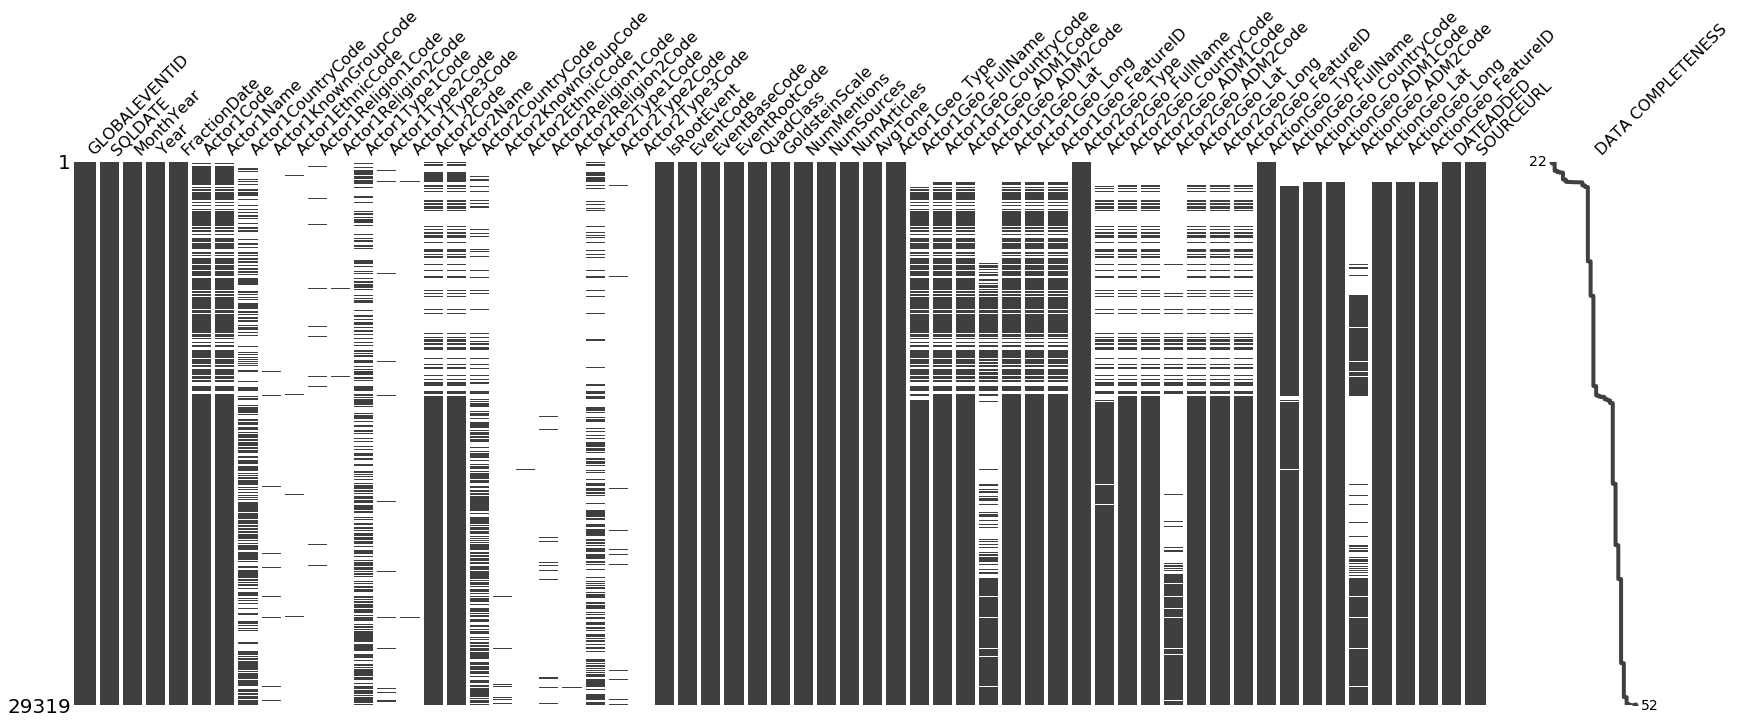

In [48]:
mno.matrix(gdelt_events, sort='ascending', labels=True)
plt.show()

# 3. Exploratory Data Analysis on GDELT Mentions

In [49]:
gdelt_mentions.head(10)

,GLOBALEVENTID,EventTimeDate,MentionTimeDate,MentionType,MentionSourceName,MentionIdentifier,SentenceID,Actor1CharOffset,Actor2CharOffset,ActionCharOffset,InRawText,Confidence,MentionDocLen,MentionDocTone,MentionDocTranslationInfo,Extras
0,410412347,20150218230000,20150218230000,1,dailymaverick.co.za,http://www.dailymaverick.co.za/article/2015-02...,19,-1,4594,4634,1,50,6665,-4.477612,NaN,NaN
1,410412348,20150218230000,20150218230000,1,indiatimes.com,http://timesofindia.indiatimes.com/city/bengal...,2,-1,300,344,1,50,2541,2.078522,NaN,NaN
2,410412349,20150218230000,20150218230000,1,voxy.co.nz,http://www.voxy.co.nz/entertainment/coast-new-...,4,-1,1297,1232,0,10,2576,7.517084,NaN,NaN
3,410412350,20150218230000,20150218230000,1,voxy.co.nz,http://www.voxy.co.nz/entertainment/coast-new-...,4,-1,1298,1233,1,20,2576,7.517084,NaN,NaN
4,410412351,20150218230000,20150218230000,1,eastidahonews.com,http://www.eastidahonews.com/2015/02/neil-patr...,1,-1,103,122,1,100,1432,0.000000,NaN,NaN
5,410368256,20150218193000,20150218230000,1,businessinsider.com.au,http://www.businessinsider.com.au/australian-g...,4,1325,-1,1356,0,20,1628,0.000000,NaN,NaN
6,410290898,20150218141500,20150218230000,1,blayneychronicle.com.au,http://www.blayneychronicle.com.au/story/28933...,12,2675,-1,2705,1,50,3345,0.530035,NaN,NaN
7,410290898,20150218141500,20150218230000,1,murrayvalleystandard.com.au,http://www.murrayvalleystandard.com.au/story/2...,12,2675,-1,2705,1,50,3345,0.530035,NaN,NaN
8,410290898,20150218141500,20150218230000,1,stawelltimes.com.au,http://www.stawelltimes.com.au/story/2893340/o...,12,2675,-1,2705,1,50,3345,0.530035,NaN,NaN
9,410290898,20150218141500,20150218230000,1,goondiwindiargus.com.au,http://www.goondiwindiargus.com.au/story/28933...,12,2675,-1,2705,1,50,3345,0.530035,NaN,NaN


In [50]:
gdelt_mentions.nunique().sort_values(ascending=False).head(15)

GLOBALEVENTID                42614
MentionIdentifier            15694
MentionDocTone                8832
ActionCharOffset              6765
Actor1CharOffset              6583
Actor2CharOffset              6199
MentionDocLen                 5148
MentionSourceName             4058
EventTimeDate                  238
SentenceID                      78
MentionDocTranslationInfo       53
Confidence                      10
MentionTimeDate                  8
InRawText                        2
MentionType                      2
dtype: int64

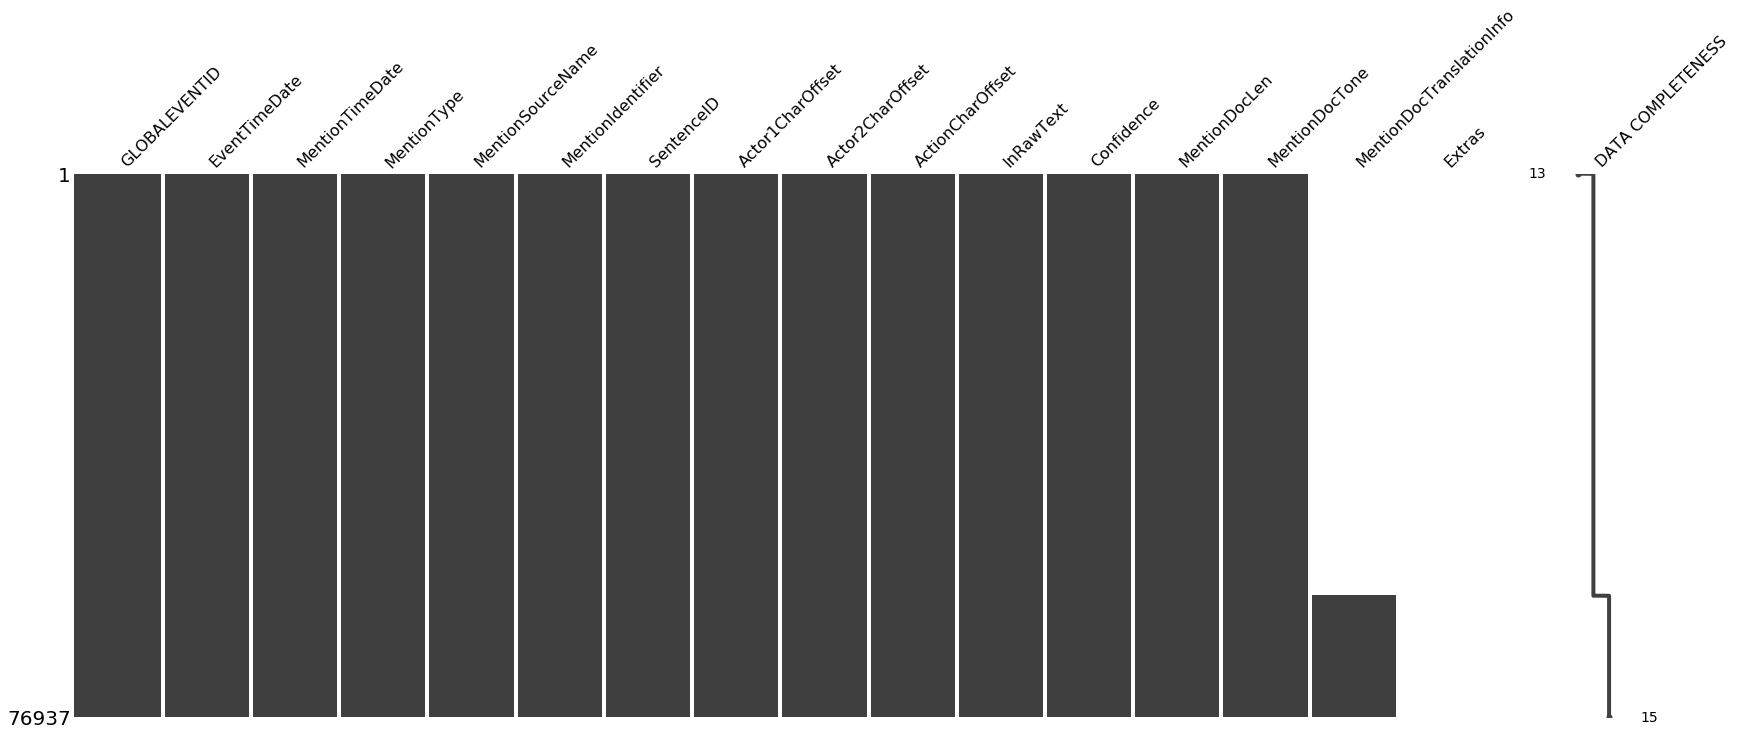

In [51]:
mno.matrix(gdelt_mentions, sort='ascending', labels=True)
plt.show()

# 4. Exploratory Data Analysis on GDELT GKG

In [54]:
gdelt_gkg.head()

,GKGRECORDID,DATE,SourceCollectionIdentifier,SourceCommonName,DocumentIdentifier,Counts,V2Counts,Themes,V2Themes,Locations,...,GCAM,SharingImage,RelatedImages,SocialImageEmbeds,SocialVideoEmbeds,Quotations,AllNames,Amounts,TranslationInfo,Extras
0,20150218230000-0,20150218230000,2,BBC Monitoring,as listed in Russian /BBC Monitoring/(c) BBC,"ARREST#400#political#4#Rossiya, Orenburgskaya ...","ARREST#400#political#4#Rossiya, Orenburgskaya ...",TERROR;REBELS;TAX_ETHNICITY;TAX_ETHNICITY_UKRA...,"TAX_FNCACT,2011;TAX_FNCACT,3449;TAX_FNCACT,381...","4#Budapest, Budapest, Hungary#RS#HU05#47.5#19....",...,"wc:693,c1.1:1,c1.2:1,c12.1:43,c12.10:58,c12.11...",NaN,NaN,NaN,NaN,1332|134||prisoners are treated humanely ; the...,"Channel One,628;Channel One,755;Channel One,14...","3,channels,476;3,channels reported,824;1,corre...",NaN,NaN
1,20150218230000-1,20150218230000,2,BBC Monitoring,"Al-Sharq al-Awsat website, London/BBC Monitori...",NaN,NaN,TAX_FNCACT;TAX_FNCACT_ENVOY;TAX_ETHNICITY;TAX_...,"IDEOLOGY,6790;IDEOLOGY,10592;KILL,1960;KILL,13...",1#Qatar#SA#QA#25.5#51.25#QA;1#Syria#SA#SY#35#3...,...,"wc:2376,c1.2:1,c1.4:7,c12.1:163,c12.10:276,c12...",NaN,NaN,NaN,NaN,332|26||greatly complicate matters#4494|37||ma...,"Emrullah Isler,83;Arab Spring,3571;Development...","2,fronts at the political,1455;2,main strategi...",NaN,NaN
2,20150218230000-2,20150218230000,1,wjon.com,http://wjon.com/wjon-news-on-demand-wednesday-...,NaN,NaN,MANMADE_DISASTER;MANMADE_DISASTER_WITHOUT_POWE...,"MANMADE_DISASTER,91;POWER_OUTAGE,91;",NaN,...,"wc:93,c12.1:7,c12.10:10,c12.12:5,c12.13:4,c12....",http://wac.450F.edgecastcdn.net/80450F/wjon.co...,http:/wac.450F.edgecastcdn.net/80450F/wjon.com...,NaN,https://youtube.com/channel/;https://youtube.c...,NaN,"Waite Park,125;City Food,233;Adobe Flash Playe...","500,people were without power,51;",NaN,NaN
3,20150218230000-3,20150218230000,1,wjol.com,http://www.wjol.com/common/more.php?m=15&r=3&i...,NaN,NaN,LEADER;TAX_FNCACT;TAX_FNCACT_GOVERNOR;TAX_POLI...,"TAX_FNCACT,131;TAX_POLITICAL_PARTY,664;TAX_FNC...","2#Wisconsin, United States#US#USWI#44.2563#-89...",...,"wc:103,c12.1:4,c12.10:13,c12.12:7,c12.13:6,c12...",NaN,NaN,NaN,NaN,NaN,"Governor Rauner,41;Speaker Michael Madigan,158...",NaN,NaN,NaN
4,20150218230000-4,20150218230000,1,straitstimes.com,http://www.straitstimes.com:80/news/world/unit...,NaN,NaN,DRONES;TAX_WORLDMAMMALS;TAX_WORLDMAMMALS_MICE;...,"TAX_FNCACT,634;TAX_FNCACT,1248;TAX_FNCACT,907;...","1#United States#US#US#38#-97#US;3#Miami, Flori...",...,"wc:255,c12.1:10,c12.10:28,c12.12:11,c12.13:7,c...",http://www.straitstimes.com/sites/straitstimes...,NaN,NaN,NaN,NaN,"United States,583;Columbia University Medical ...","5,weeks,1194;",NaN,NaN


In [55]:
gdelt_gkg.nunique().sort_values(ascending=False).head(15)

DocumentIdentifier    35846
GKGRECORDID           34656
V2Tone                29490
GCAM                  29472
AllNames              28624
V2Themes              26447
Themes                23088
V2Locations           22568
V2Organizations       19233
Amounts               19166
V2Persons             18285
SharingImage          18235
Organizations         15093
Persons               14768
Locations             14373
dtype: int64

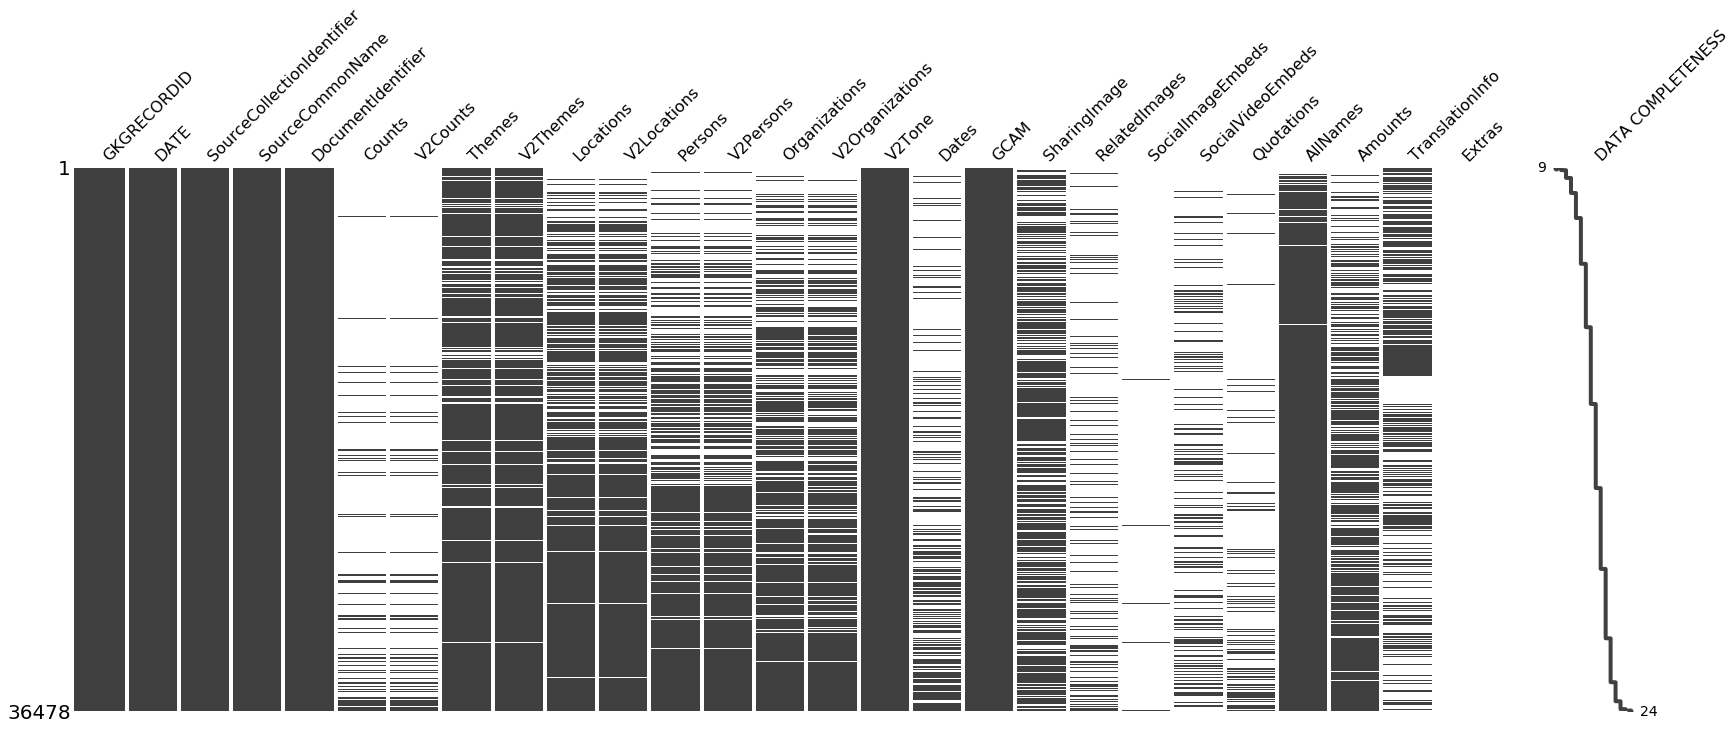

In [56]:
mno.matrix(gdelt_gkg, sort='ascending', labels=True)
plt.show()

# 5. Queries

## 5.1. Afficher le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article)

- `SQLDATE`
- `NumArticles`
- `NumMentions`

In [57]:
gdelt_events[['GLOBALEVENTID', 'SQLDATE', 'NumArticles', 'NumMentions', 'SOURCEURL']].head()

,GLOBALEVENTID,SQLDATE,NumArticles,NumMentions,SOURCEURL
0,410412347,20140218,5,5,http://www.dailymaverick.co.za/article/2015-02...
1,410412348,20140218,5,5,http://timesofindia.indiatimes.com/city/bengal...
2,410412349,20140218,1,1,http://www.voxy.co.nz/entertainment/coast-new-...
3,410412350,20140218,2,2,http://www.voxy.co.nz/entertainment/coast-new-...
4,410412351,20140218,10,10,http://www.eastidahonews.com/2015/02/neil-patr...


In [58]:
gdelt_events.isnull().sum().sort_values().head(20)

GLOBALEVENTID     0
ActionGeo_Type    0
Actor2Geo_Type    0
Actor1Geo_Type    0
AvgTone           0
NumArticles       0
NumSources        0
NumMentions       0
DATEADDED         0
QuadClass         0
EventRootCode     0
EventBaseCode     0
EventCode         0
IsRootEvent       0
GoldsteinScale    0
SOURCEURL         0
SQLDATE           0
MonthYear         0
Year              0
FractionDate      0
dtype: int64

In [59]:
gdelt_events[['ActionGeo_Type', 'Actor2Geo_Type', 'Actor1Geo_Type', 'ActionGeo_CountryCode']].head()

,ActionGeo_Type,Actor2Geo_Type,Actor1Geo_Type,ActionGeo_CountryCode
0,4,4,0,SF
1,4,4,0,IN
2,4,1,0,AS
3,1,1,0,NZ
4,2,2,0,US


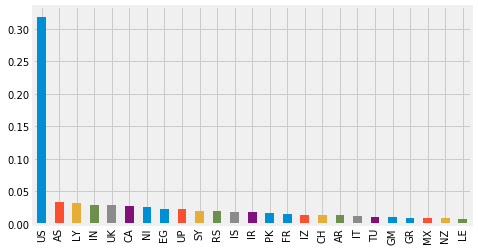

In [60]:
f, ax = plt.subplots(figsize=(7,4))
gdelt_events['ActionGeo_CountryCode'].value_counts(True).head(25).plot(kind='bar', ax=ax)
plt.show()

- `MentionDocTranslationInfo`: This field is internally delimited by semicolons and is used
to record provenance information for machine translated documents indicating the original
source language and the citation of the translation system used to translate the document for
processing. It will be blank for documents originally in English. SRCLC. This is the Source Language Code, representing the three-letter ISO639-2 code of the language of the original source material. 

Regex: "srclc:[a-z][a-z][a-z]"

In [66]:
# gdelt_mentions[['GLOBALEVENTID', 'MentionDocTranslationInfo']].head()

In [63]:
gdelt_mentions['MentionDocTranslationInfo'] = gdelt_mentions['MentionDocTranslationInfo'].fillna('')

In [65]:
gdelt_mentions[['GLOBALEVENTID', 'MentionDocTranslationInfo']].head()

,GLOBALEVENTID,MentionDocTranslationInfo
0,410412347,
1,410412348,
2,410412349,
3,410412350,
4,410412351,


In [69]:
def get_article_mention_language(translateInfo):
    try:
        if translateInfo=='':
            language = 'eng'
        else:
            language = translateInfo.split(';', 1)[0][-3:]
    except:
        language = '__ERROR__'
    return language

gdelt_mentions['MentionDocOriginalLanguage'] = \
                    gdelt_mentions['MentionDocTranslationInfo'].apply(lambda x: get_article_mention_language(x))

gdelt_mentions['MentionDocOriginalLanguage'].value_counts()

eng    59738
spa     6405
ara     3534
fra     1825
rus     1021
por      954
deu      577
ita      313
ron      243
ell      201
tur      191
ukr      158
dan      158
swe      139
srp      134
urd      115
ind      109
pol      106
slv       86
ces       79
nor       78
lit       72
nld       67
hin       67
hun       52
fas       49
bul       46
ben       43
cat       39
heb       36
hrv       32
sqi       31
kor       30
fin       29
slk       25
isl       24
lav       24
bos       23
mal       20
mkd       17
tam       11
glg        9
est        8
afr        6
tel        5
som        3
hye        2
msa        2
pan        1
Name: MentionDocOriginalLanguage, dtype: int64

On fusionne les tables **GDELT Events** et **GDELT Mentions**:

In [77]:
gdelt_events.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,410412347,20140218,201402,2014,2014.1315,NaN,NaN,NaN,NaN,NaN,...,4,"Waterkloof, Free State, South Africa",SF,SF03,77359,-30.3098,25.2971,-1299321,20150218230000,http://www.dailymaverick.co.za/article/2015-02...
1,410412348,20140218,201402,2014,2014.1315,NaN,NaN,NaN,NaN,NaN,...,4,"Bengaluru, Karnataka, India",IN,IN19,70159,12.9833,77.5833,-2090174,20150218230000,http://timesofindia.indiatimes.com/city/bengal...
2,410412349,20140218,201402,2014,2014.1315,NaN,NaN,NaN,NaN,NaN,...,4,"Great Southern, Victoria, Australia",AS,AS07,5387,-36.0667,146.4830,-1576477,20150218230000,http://www.voxy.co.nz/entertainment/coast-new-...
3,410412350,20140218,201402,2014,2014.1315,NaN,NaN,NaN,NaN,NaN,...,1,New Zealand,NZ,NZ,NaN,-41.0000,174.0000,NZ,20150218230000,http://www.voxy.co.nz/entertainment/coast-new-...
4,410412351,20140218,201402,2014,2014.1315,NaN,NaN,NaN,NaN,NaN,...,2,"Idaho, United States",US,USID,NaN,44.2394,-114.5100,ID,20150218230000,http://www.eastidahonews.com/2015/02/neil-patr...


In [78]:
gdelt_events['GLOBALEVENTID'].unique().shape[0] / gdelt_events.shape[0]

1.0

In [79]:
gdelt_mentions['GLOBALEVENTID'].unique().shape[0] / gdelt_mentions.shape[0]

0.55388174740372

In [80]:
print(len([x for x in gdelt_mentions.GLOBALEVENTID if x not in gdelt_mentions.GLOBALEVENTID]))
print(len([x for x in gdelt_events.GLOBALEVENTID if x not in gdelt_events.GLOBALEVENTID]))

76937
29319


In [81]:
gdelt_mentions.shape, gdelt_events.shape

((76937, 17), (29319, 61))

In [82]:
gdelt_mentions_with_events = gdelt_mentions.merge(gdelt_events, on='GLOBALEVENTID', how='left')
gdelt_mentions_with_events.shape

(76937, 77)

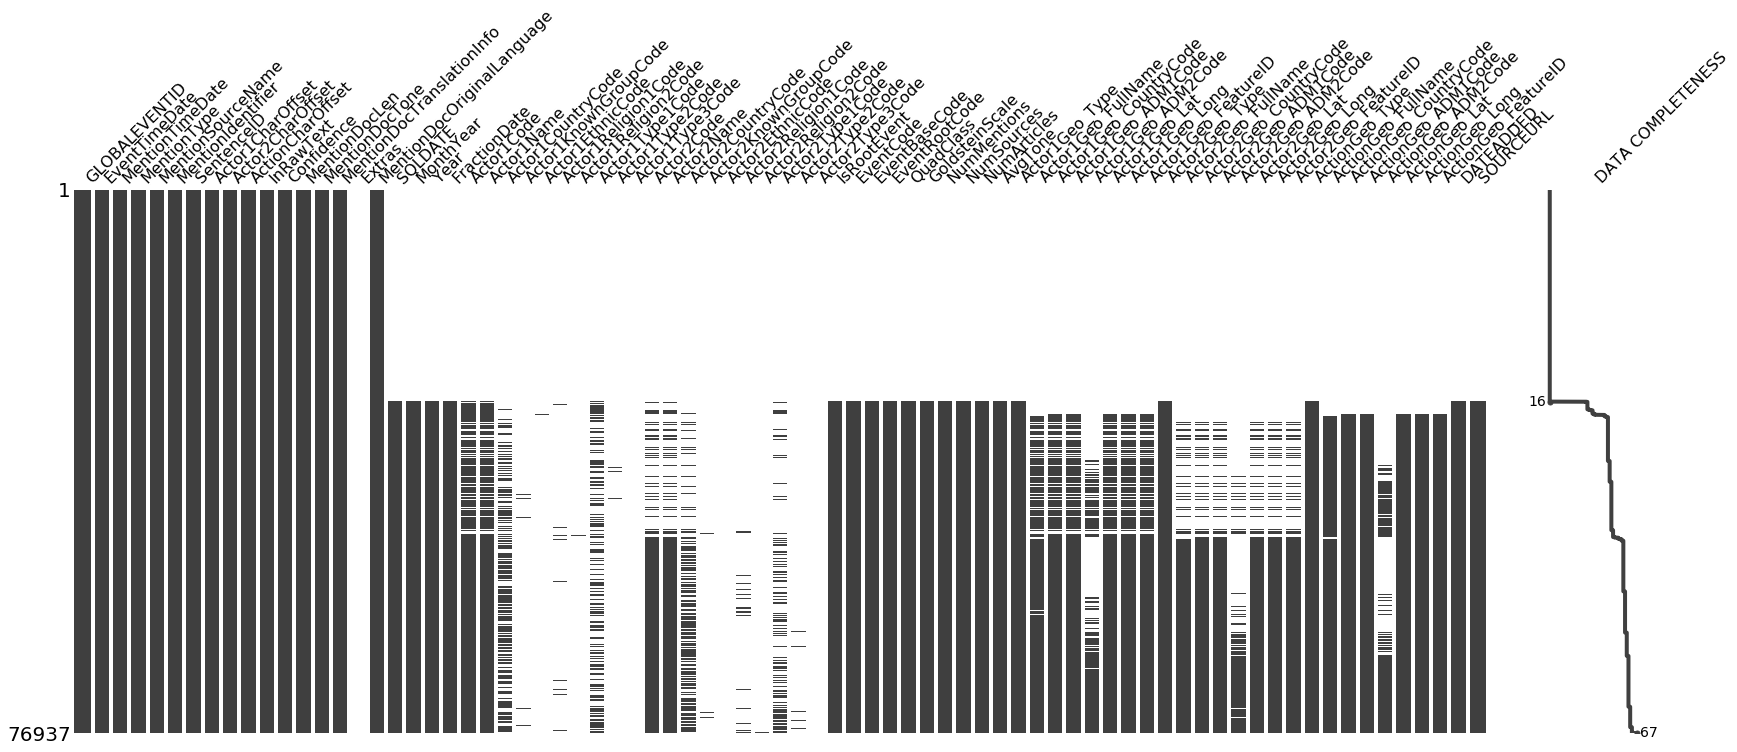

In [83]:
mno.matrix(gdelt_mentions_with_events, sort='ascending', labels=True)
plt.show()

C'est normal qu'il y a des valeurs manquantes vu que j'ai pris seulement une petite portion des données GDELT.

## 5.2. Pour un pays donné en paramètre, affichez les évènements qui y ont eu place triées par le nombre de mentions (tri décroissant); permettez une agrégation par jour/mois/année

## 5.3.

### Pour une source de donnés passée en paramètre (gkg.SourceCommonName)
### (1) Affichez les thèmes, personnes, lieux dont les articles de cette sources parlent
### (2) Ainsi que le le nombre d’articles et le ton moyen des articles (pour chaque thème/personne/lieu); permettez une agrégation par jour/mois/année

In [88]:
example_dictionary = gdelt_gkg[['SourceCommonName', 'Locations', 'V2Tone']].to_dict('records')[0]
pprint(example_dictionary)

{'Locations': '4#Budapest, Budapest, '
              'Hungary#RS#HU05#47.5#19.0833#-850553;4#Ogarevo, Kaluzhskaya '
              "Oblast', "
              'Russia#RS#RS25#55.2031#35.8328#139814;1#Hungary#RS#HU#47#20#HU;4#Rossiya, '
              "Orenburgskaya Oblast', "
              "Russia#RS#RS55#52.4#54.9833#-2993111;4#Maydan, Zakarpats'ka "
              "Oblast', "
              'Ukraine#RS#UP25#48.6031#23.4741#-1046268;1#Ukraine#RS#UP#49#32#UP;1#Russia#RS#RS#60#100#RS;4#Luhansk, '
              "Luhans'ka Oblast', "
              'Ukraine#RS#UP14#48.567#39.3171#-1045160;4#Novorossiya, '
              'Primorskiy Kray, Russia#RS#RS59#43.3427#132.556#11462001',
 'SourceCommonName': 'BBC Monitoring',
 'V2Tone': '-5.3475935828877,2.13903743315508,7.48663101604278,9.62566844919786,21.2566844919786,0.53475935828877,693'}


In [115]:
# example_dictionary = gdelt_gkg[['GKGRECORDID', 'DATE', 'AllNames', 'Themes',
#                                 'Quotations', 'SourceCommonName']].to_dict('records')[0]
# pprint(example_dictionary)
pprint(gdelt_gkg.transpose().iloc[:,0].to_dict())

{'AllNames': 'Channel One,628;Channel One,755;Channel One,1449;Channel '
             'One,1672;Gen Aleksandr Lentsov,1994;Eduard '
             'Basuryn,2123;Ukrainian President Petro Poroshenko,2410;Sergey '
             'Mikheyev,2552;Hungarian Prime Minister Viktor Orban,2877;Deputy '
             'Prime Minister Arkadiy Dvorkovich,3603;Deputy Prime Minister '
             'Dvorkovich,3985;Channel One,4835',
 'Amounts': '3,channels,476;3,channels reported,824;1,correspondent '
            'said,1101;1,showed,1406;3,channels mocked Ukrainian '
            'President,1883;3,channels showed Putin saying,2604;2,weeks '
            'ago,2843;300,commuter train lines,2944;1,presenter '
            'said,3469;400,political prisoners,3661;',
 'Counts': "ARREST#400#political#4#Rossiya, Orenburgskaya Oblast', "
           'Russia#RS#RS55#52.4#54.9833#-2993111;',
 'DATE': 20150218230000,
 'Dates': nan,
 'DocumentIdentifier': 'as listed in Russian /BBC Monitoring/(c) BBC',
 'Extras': nan,
 'GC

## 5.4. Dresser la cartographie des relations entre les pays d’après le ton des articles : pour chaque paire (pays1, pays2), calculer le nombre d’article, le ton moyen (aggrégations sur Année/Mois/Jour, filtrage par pays ou carré de coordonnées)